<a href="https://colab.research.google.com/github/Kaiziferr/deep_learning_workshop/blob/master/RNN/01_workshop_LSTM_time_series_time_windows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# **Contexto**
---
- LSTM para un problema de regresión con secuencialidad temporal.
- LSTM usando una ventana y pasos de tiempo
- Desarrollar y hacer predicciones que mantienen el estado (memoria) en secuencias muy largas.




# **Data**
---
Este es un problema en el que, dado un año y un mes, la tareas es predecir el número de pasajeros de aerolineas internecionales en unidades de 1.000. Los datos van desde enero de 1949 hasta diciembre de 1960 o 12 años, con 144 observaciones.


In [2]:
url = 'https://raw.githubusercontent.com/jinfagang/LSTM_learn/master/international-airline-passengers.csv'
data = pd.read_csv(url, usecols=[1], engine="python")
data_values = data.values.astype('float32')

#**Normalización**
---

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_values = scaler.fit_transform(data_values)

In [4]:
data_values[:5]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]], dtype=float32)

# **Data Split**
---



In [5]:
train_size = int(len(data_values)*0.67)
test_size = len(data_values) - train_size
train, test =  data_values[:train_size,:], data_values[train_size:, :]

# **Create Data**
---
**Se crea un paso de tiempo de 1** 


In [6]:
def create_dataset(data, loock_back = 1):
  dataX, dataY = [], []
  for i in range(len(data)-loock_back-1): 
    item_x = data[i: (i+loock_back), 0]
    item_y = data[i+loock_back,0]
    dataX.append(item_x)
    dataY.append(item_y)
  return np.array(dataX), np.array(dataY)

In [7]:
loock_back = 1
trainX, trainY = create_dataset(train, loock_back)
testX, testY = create_dataset(test, loock_back)

La red LSTM espera que los datos de entrada (X) se proporcionen con una estructura de matriz especifica en forma de [muestras, pasos de tiempo (ventana), caracteristicas]<br><br>
Los datos preparados tienen la forma: [muestras, carcteristicas]<br><br>

In [8]:
print(f'El conjunto de estara dado con {trainX.shape[0]} muestras registros y con {trainX.shape[1]} caracteristicas')
print('En esta primera pruebas los pasos de tiempo seran 1')

El conjunto de estara dado con 94 muestras registros y con 1 caracteristicas
En esta primera pruebas los pasos de tiempo seran 1


In [9]:
print(f'Hacemos un reformateo para cumplir [muestras, pasos de tiempo (ventana), caracteristicas] {trainX.shape}')
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(f'Obtenemos {trainX.shape}')

Hacemos un reformateo para cumplir [muestras, pasos de tiempo (ventana), caracteristicas] (94, 1)
Obtenemos (94, 1, 1)


# **Diseño de LSTM**
---
- Capa visible con 1 entrada
- Capa oculta con 4 bloques LSTM o neuronas
- Capa de salida que hace una predicción de valor unico. LSTM utiliza por defecto la función sigmoidal
- 100 epocas y batch


- (1, loock_back) Indica una entrada con un tamaño de ventana de 1

In [10]:
model = Sequential()
model.add(LSTM(4, input_shape = (1, loock_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs = 100, batch_size = 1, verbose = 0)

# **Predicción**
---



In [11]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# **Resultados**
---



In [12]:
train_inverse_predict_X = scaler.inverse_transform(train_predict)
train_inverse_y = scaler.inverse_transform([trainY])

test_inverse_predic_X = scaler.inverse_transform(test_predict)
test_inverse_y = scaler.inverse_transform([testY])

# **Calcular el error**
---


In [13]:
train_score = math.sqrt(mean_squared_error(train_inverse_y[0], train_inverse_predict_X[:,0]))
print('Puntuación Entrenamiento %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = math.sqrt(mean_squared_error(test_inverse_y[0], test_inverse_predic_X[:,0]))
print('Puntuación Validación %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

Puntuación Entrenamiento 22.78 MSE (4.77 RMSE)
Puntuación Validación 53.00 MSE (7.28 RMSE)


In [14]:
print(f"El modelo falla en aprocimadamente {math.sqrt(train_score)} mil pasajeros por mes para los datos de entrenamiento")
print(f"El modelo falla en aprocimadamente {math.sqrt(test_score)} mil para los datos de validación ")

El modelo falla en aprocimadamente 4.773307055692609 mil pasajeros por mes para los datos de entrenamiento
El modelo falla en aprocimadamente 7.280420899813477 mil para los datos de validación 


# Plot

In [15]:
train_predict_plot = np.empty_like(data_values)
train_predict_plot[:,:] = np.nan
train_predict_plot[loock_back: len(train_inverse_predict_X)+loock_back, :] = train_inverse_predict_X

test_predict_plot = np.empty_like(data_values)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_inverse_predict_X)+(loock_back*2)+1:len(data_values)-1,:] = test_inverse_predic_X

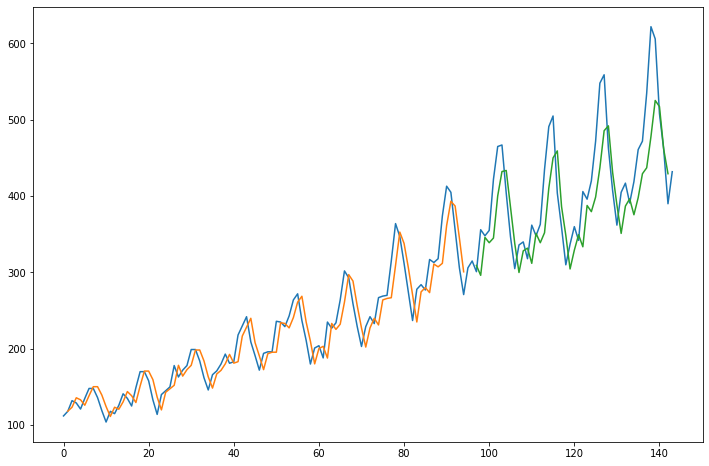

In [16]:
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data_values))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()

# **Create Data**
---
**Se crea un paso de tiempo de 3**

In [17]:
loock_back = 3
trainX, trainY = create_dataset(train, loock_back)
testX, testY = create_dataset(test, loock_back)

In [18]:
print(f'Hacemos un reformateo para cumplir [muestras, pasos de tiempo (ventana), caracteristicas] {trainX.shape}')
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(f'Obtenemos {trainX.shape}')

Hacemos un reformateo para cumplir [muestras, pasos de tiempo (ventana), caracteristicas] (92, 3)
Obtenemos (92, 1, 3)


# **Model**
---



In [19]:
model = Sequential()
model.add(LSTM(4, input_shape = (1, loock_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs = 100, batch_size = 1, verbose = 0)

# **Predicción**
---


In [20]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# **Resultados**
---

In [21]:
train_inverse_predict_X = scaler.inverse_transform(train_predict)
train_inverse_y = scaler.inverse_transform([trainY])

test_inverse_predic_X = scaler.inverse_transform(test_predict)
test_inverse_y = scaler.inverse_transform([testY])

# **Calcular el error**
---


In [22]:
train_score = math.sqrt(mean_squared_error(train_inverse_y[0], train_inverse_predict_X[:,0]))
print('Puntuación Entrenamiento %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = math.sqrt(mean_squared_error(test_inverse_y[0], test_inverse_predic_X[:,0]))
print('Puntuación Validación %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

Puntuación Entrenamiento 22.30 MSE (4.72 RMSE)
Puntuación Validación 42.69 MSE (6.53 RMSE)


In [23]:
print(f"El modelo falla en aprocimadamente {math.sqrt(train_score)} mil pasajeros por mes para los datos de entrenamiento")
print(f"El modelo falla en aprocimadamente {math.sqrt(test_score)} mil para los datos de validación ")

El modelo falla en aprocimadamente 4.722065230952242 mil pasajeros por mes para los datos de entrenamiento
El modelo falla en aprocimadamente 6.533900876587058 mil para los datos de validación 


In [24]:
train_predict_plot = np.empty_like(data_values)
train_predict_plot[:,:] = np.nan
train_predict_plot[loock_back: len(train_inverse_predict_X)+loock_back, :] = train_inverse_predict_X

test_predict_plot = np.empty_like(data_values)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_inverse_predict_X)+(loock_back*2)+1:len(data_values)-1,:] = test_inverse_predic_X

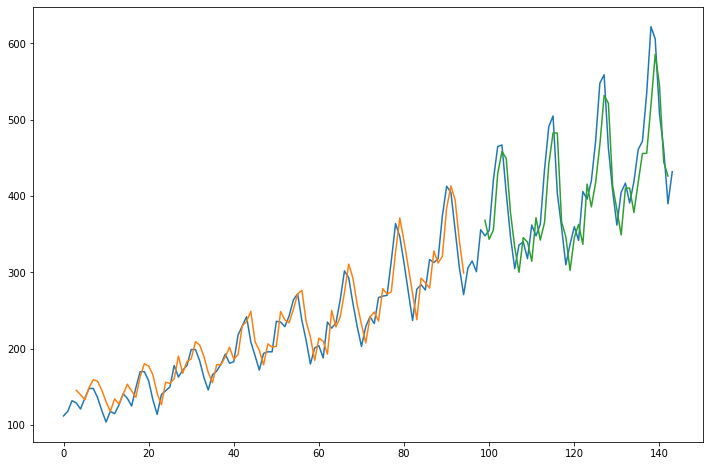

In [25]:
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data_values))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()